### **1. Importar librerías y configurar entorno** ###

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
from wordcloud import WordCloud

# Configuración de estilo
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,5)

DATA_PATH = "../data/processed/rockyou_clean.csv"



### **2.Carga del Dataset** ### 

In [2]:
df = pd.read_csv(DATA_PATH)

print("Tamaño del dataset:", len(df))
df.head()

Tamaño del dataset: 14337576


,password
0,123456
1,12345
2,123456789
3,password
4,iloveyou


### **3.Estadísticas descriptivas básicas** ###

Longitud mínima: 3
Longitud máxima: 30
Promedio: 8.737558078157702
Mediana: 8.0


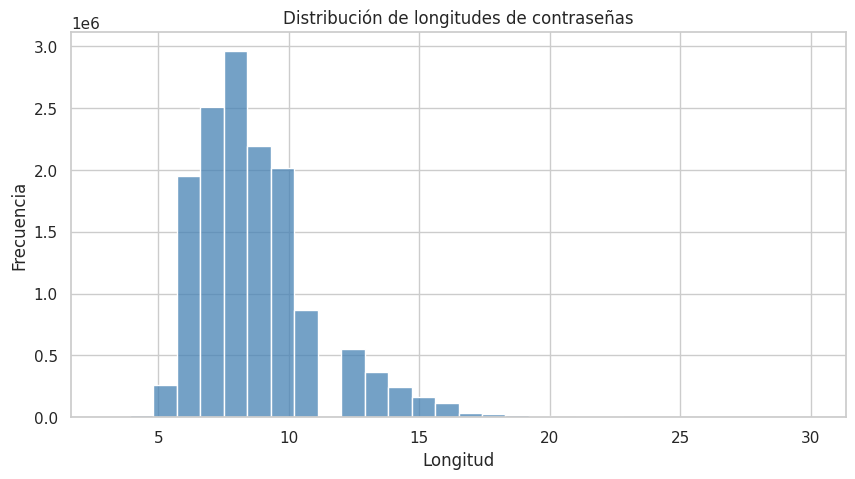

In [3]:
# Longitud de cada contraseña
df["length"] = df["password"].astype(str).apply(len)

print("Longitud mínima:", df["length"].min())
print("Longitud máxima:", df["length"].max())
print("Promedio:", df["length"].mean())
print("Mediana:", df["length"].median())

# Histograma de longitudes
sns.histplot(df["length"], bins=30, kde=False, color="steelblue")
plt.title("Distribución de longitudes de contraseñas")
plt.xlabel("Longitud")
plt.ylabel("Frecuencia")
plt.show()


### **4. Definir funciones de entropía** ###

In [4]:
import math
from collections import Counter

def entropy_shannon(pw: str) -> float:
    """Shannon entropy: medida clásica de incertidumbre."""
    if not pw: return 0
    freq = Counter(pw)
    n = len(pw)
    return -sum((count/n) * math.log2(count/n) for count in freq.values())

def min_entropy(pw: str) -> float:
    """Min-entropy: dominada por el símbolo más probable."""
    if not pw: return 0
    freq = Counter(pw)
    n = len(pw)
    p_max = max(count/n for count in freq.values())
    return -math.log2(p_max)

def guessing_entropy(pw: str) -> float:
    """
    Guessing entropy: esperanza de intentos hasta adivinar.
    Simplificación: 2^(Shannon entropy - 1)
    """
    H = entropy_shannon(pw)
    return 2**(H - 1) if H > 0 else 0

def combinatorial_entropy(pw: str) -> float:
    """
    Combinatorial entropy: log2(N^m), donde N = tamaño del alfabeto usado, m = longitud.
    """
    if not pw: return 0
    alphabet = set()
    for c in pw:
        if c.islower(): alphabet.add("lower")
        elif c.isupper(): alphabet.add("upper")
        elif c.isdigit(): alphabet.add("digit")
        else: alphabet.add("symbol")
    N = 0
    if "lower" in alphabet: N += 26
    if "upper" in alphabet: N += 26
    if "digit" in alphabet: N += 10
    if "symbol" in alphabet: N += 32  # aproximado
    m = len(pw)
    return m * math.log2(N) if N > 0 else 0


### **6. Calcular entropías para el dataset** ###

In [5]:
df["entropy_shannon"] = df["password"].astype(str).apply(entropy_shannon)
df["entropy_min"] = df["password"].astype(str).apply(min_entropy)
df["entropy_guessing"] = df["password"].astype(str).apply(guessing_entropy)
df["entropy_combinatorial"] = df["password"].astype(str).apply(combinatorial_entropy)

df[["password","entropy_shannon","entropy_min","entropy_guessing","entropy_combinatorial"]].head()


,password,entropy_shannon,entropy_min,entropy_guessing,entropy_combinatorial
0,123456,2.584963,2.584963,3.000000,19.931569
1,12345,2.321928,2.321928,2.500000,16.609640
2,123456789,3.169925,3.169925,4.500000,29.897353
3,password,2.750000,2.000000,3.363586,37.603518
4,iloveyou,2.750000,2.000000,3.363586,37.603518


In [6]:
print("Valores medios de entropía:")
print("Shannon:", df["entropy_shannon"].mean())
print("Min:", df["entropy_min"].mean())
print("Guessing:", df["entropy_guessing"].mean())
print("Combinatorial:", df["entropy_combinatorial"].mean())


Valores medios de entropía:
Shannon: 2.679195332564104
Min: 2.1469514114296215
Guessing: 3.3335933084496276
Combinatorial: 42.37744584172095


In [7]:
print("Valores extremos:")

for col in ["entropy_shannon","entropy_min","entropy_guessing","entropy_combinatorial"]:
    min_val = df[col].min()
    max_val = df[col].max()
    pw_min = df.loc[df[col].idxmin(), "password"]
    pw_max = df.loc[df[col].idxmax(), "password"]
    print(f"{col}:")
    print(f"  Min {min_val:.3f} → '{pw_min}'")
    print(f"  Max {max_val:.3f} → '{pw_max}'")


Valores extremos:
entropy_shannon:
  Min -0.000 → '111111'
  Max 4.907 → 'qazwsxedcrfvtgbyhnujmik,ol.p;/'
entropy_min:
  Min -0.000 → '111111'
  Max 4.907 → 'qazwsxedcrfvtgbyhnujmik,ol.p;/'
entropy_guessing:
  Min 0.000 → '111111'
  Max 15.000 → 'qazwsxedcrfvtgbyhnujmik,ol.p;/'
entropy_combinatorial:
  Min 13.288 → '1234'
  Max 196.638 → 'Kirapandora.,.,despierten91238'


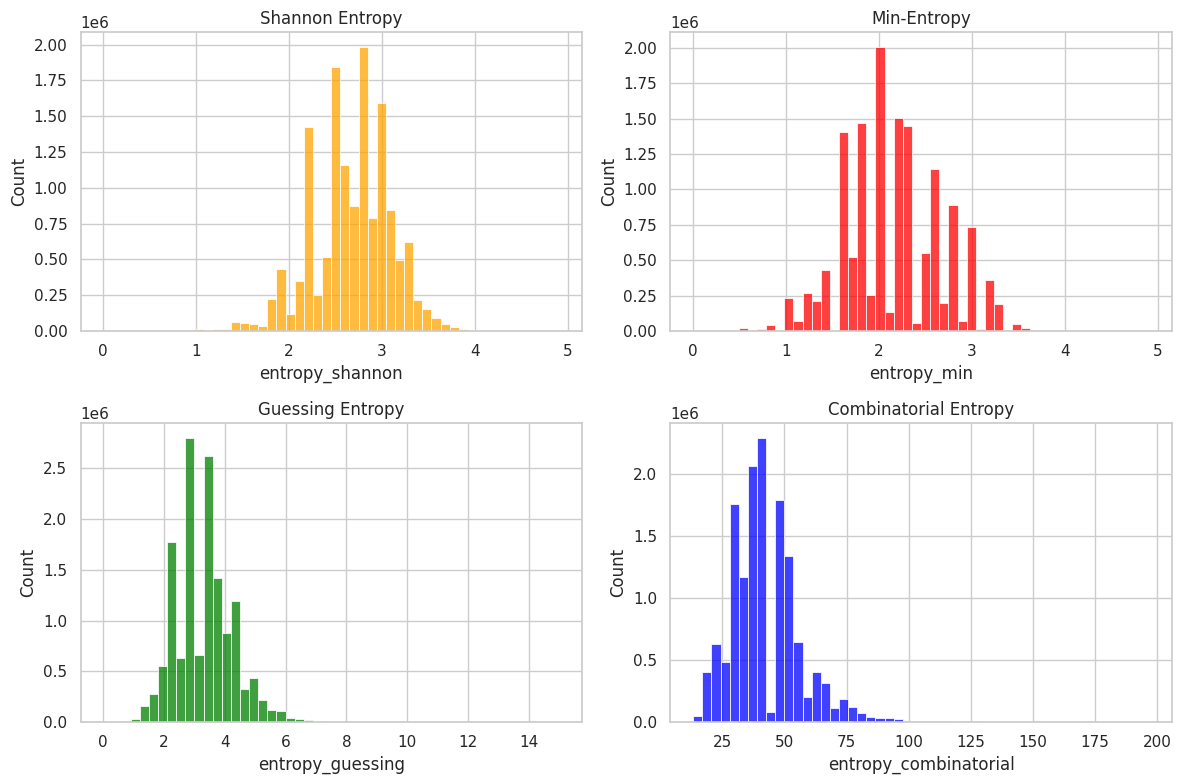

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))

sns.histplot(df["entropy_shannon"], bins=50, ax=axes[0,0], color="orange")
axes[0,0].set_title("Shannon Entropy")

sns.histplot(df["entropy_min"], bins=50, ax=axes[0,1], color="red")
axes[0,1].set_title("Min-Entropy")

sns.histplot(df["entropy_guessing"], bins=50, ax=axes[1,0], color="green")
axes[1,0].set_title("Guessing Entropy")

sns.histplot(df["entropy_combinatorial"], bins=50, ax=axes[1,1], color="blue")
axes[1,1].set_title("Combinatorial Entropy")

plt.tight_layout()
plt.show()


### **7. Top 20 contraseñas más comunes** ###

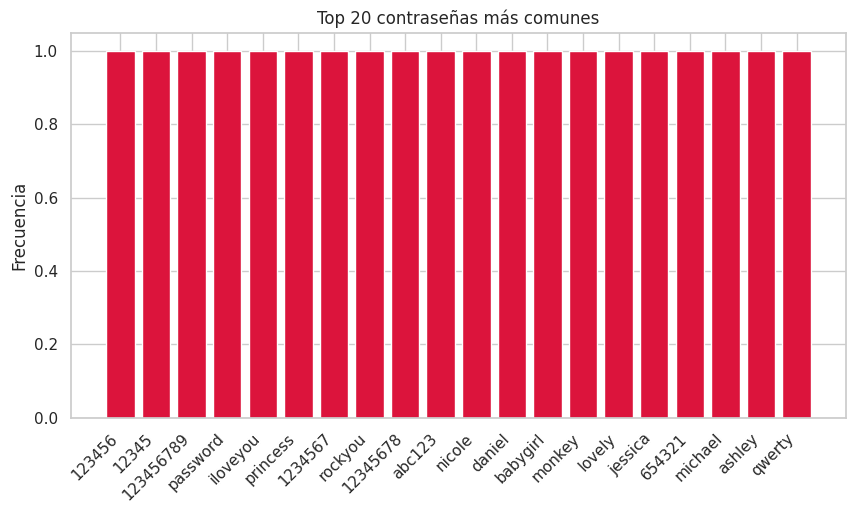

password
123456       1
12345        1
123456789    1
password     1
iloveyou     1
princess     1
1234567      1
rockyou      1
12345678     1
abc123       1
nicole       1
daniel       1
babygirl     1
monkey       1
lovely       1
jessica      1
654321       1
michael      1
ashley       1
qwerty       1
Name: count, dtype: int64

In [9]:
top20 = df["password"].value_counts().head(20)

plt.bar(top20.index, top20.values, color="crimson")
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 contraseñas más comunes")
plt.ylabel("Frecuencia")
plt.show()

top20


### **8.Patrones morfológicos** ###

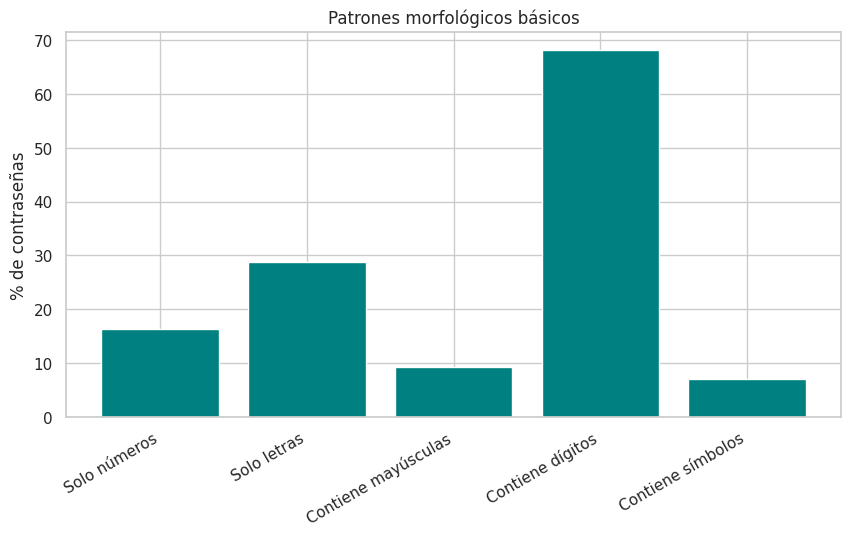

{'Solo números': np.float64(0.1636441308938227),
 'Solo letras': np.float64(0.2868964242558452),
 'Contiene mayúsculas': np.float64(0.0931232094688258),
 'Contiene dígitos': np.float64(0.6809141015827292),
 'Contiene símbolos': np.float64(0.07075659586785074)}

In [10]:
df["is_numeric"] = df["password"].str.isdigit()
df["is_alpha"]   = df["password"].str.isalpha()
df["has_upper"]  = df["password"].str.contains(r"[A-Z]")
df["has_digit"]  = df["password"].str.contains(r"[0-9]")
df["has_symbol"] = df["password"].str.contains(r"[^A-Za-z0-9]")

morph_stats = {
    "Solo números": df["is_numeric"].mean(),
    "Solo letras": df["is_alpha"].mean(),
    "Contiene mayúsculas": df["has_upper"].mean(),
    "Contiene dígitos": df["has_digit"].mean(),
    "Contiene símbolos": df["has_symbol"].mean(),
}

plt.bar(morph_stats.keys(), [v*100 for v in morph_stats.values()], color="teal")
plt.ylabel("% de contraseñas")
plt.xticks(rotation=30, ha="right")
plt.title("Patrones morfológicos básicos")
plt.show()

morph_stats


### **9.Patrones triviales humanos** ###

In [11]:
# Eliminar filas sin password
missing_before = df["password"].isna().sum()
df = df[~df["password"].isna()]

# Serie segura en minúsculas (casefold > lower)
s_pw = df["password"].astype("string").str.casefold()

print(f"Filas sin password eliminadas: {missing_before}")
print(f"Total filas tras limpieza: {len(df)}")


Filas sin password eliminadas: 1
Total filas tras limpieza: 14337575


In [ ]:
import re
from wordfreq import top_n_list, zipf_frequency
import string
import unicodedata
from typing import List, Set


def normalize_ascii_lower(s: str) -> str:
    if s is None:
        return ""
    s = unicodedata.normalize("NFKD", s)
    s = "".join(c for c in s if not unicodedata.combining(c))
    return s.lower()


def has_seq_numeric(s: str, min_len: int = 4) -> bool:
    run_up = run_down = 1
    prev = ""
    for ch in s:
        if ch.isdigit():
            if prev.isdigit():
                d, p = ord(ch) - 48, ord(prev) - 48
                diff = d - p
                if diff == 1:
                    run_up += 1; run_down = 1
                elif diff == -1:
                    run_down += 1; run_up = 1
                else:
                    run_up = run_down = 1
            else:
                run_up = run_down = 1
            if run_up >= min_len or run_down >= min_len:
                return True
        else:
            run_up = run_down = 1
        prev = ch
    return False


def has_seq_alpha(s: str, min_len: int = 4) -> bool:
    run_up = run_down = 1
    prev = ""
    for ch in s:
        if 'a' <= ch <= 'z':
            if 'a' <= prev <= 'z':
                diff = ord(ch) - ord(prev)
                if diff == 1:
                    run_up += 1; run_down = 1
                elif diff == -1:
                    run_down += 1; run_up = 1
                else:
                    run_up = run_down = 1
            else:
                run_up = run_down = 1
            if run_up >= min_len or run_down >= min_len:
                return True
        else:
            run_up = run_down = 1
        prev = ch
    return False


# Patrones de teclado (walks)
QWERTY_US = [
    "1234567890",
    "qwertyuiop",
    "asdfghjkl;",
    "zxcvbnm",
]

QWERTY_ES = [
    "1234567890",
    "qwertyuiop",
    "asdfghjklñ",
    "zxcvbnm",
]

NUMPAD = [
    "789",
    "456",
    "123",
    "0",
]

def _rows(grid: List[str]) -> List[str]:
    return [r for r in grid if r]

def _cols(grid: List[str]) -> List[str]:
    L = max(len(r) for r in grid)
    cols = []
    for c in range(L):
        col = "".join(r[c] for r in grid if c < len(r))
        if len(col) >= 2:
            cols.append(col)
    return cols

def _diags(grid: List[str]) -> List[str]:
    # principales (\) y secundarias (/)
    lines = []
    R = len(grid); C = max(len(r) for r in grid)
    # normaliza con padding
    norm = [r.ljust(C, "\0") for r in grid]

    # \ diagonales
    for sr in range(R):
        r, c, acc = sr, 0, []
        while r < R and c < C:
            ch = norm[r][c]
            if ch != "\0": acc.append(ch)
            r += 1; c += 1
        if len(acc) >= 3: lines.append("".join(acc))
    for sc in range(1, C):
        r, c, acc = 0, sc, []
        while r < R and c < C:
            ch = norm[r][c]
            if ch != "\0": acc.append(ch)
            r += 1; c += 1
        if len(acc) >= 3: lines.append("".join(acc))

    # / diagonales
    for sc in range(C):
        r, c, acc = 0, sc, []
        while r < R and c >= 0:
            ch = norm[r][c]
            if ch != "\0": acc.append(ch)
            r += 1; c -= 1
        if len(acc) >= 3: lines.append("".join(acc))
    for sr in range(1, R):
        r, c, acc = sr, C-1, []
        while r < R and c >= 0:
            ch = norm[r][c]
            if ch != "\0": acc.append(ch)
            r += 1; c -= 1
        if len(acc) >= 3: lines.append("".join(acc))

    # únicos
    seen, out = set(), []
    for s in lines:
        if s not in seen:
            seen.add(s); out.append(s)
    return out

def build_keyboard_regex(min_len: int = 4,
                         layouts: List[List[str]] = None,
                         include_numpad: bool = False,
                         include_diagonals: bool = False,
                         max_len: int = 6) -> re.Pattern:
    if layouts is None:
        layouts = [QWERTY_US]  # añade QWERTY_ES si lo necesitas

    lines: List[str] = []
    for grid in layouts:
        lines.extend(_rows(grid))
        lines.extend(_cols(grid))
        if include_diagonals:
            lines.extend(_diags(grid))
    if include_numpad:
        lines.extend(_rows(NUMPAD))
        lines.extend(_cols(NUMPAD))

    # Genera n-gramas normal y reverso
    seqs: Set[str] = set()
    for line in lines:
        L = len(line)
        for l in range(min_len, min(max_len, L) + 1):
            for i in range(L - l + 1):
                s = line[i:i+l]
                seqs.add(s)
                seqs.add(s[::-1])

    # Compila más largas primero
    parts = sorted(seqs, key=len, reverse=True)
    return re.compile("|".join(map(re.escape, parts)), re.IGNORECASE)




In [13]:

# --- Patrones por regex ---
SEQ_ALPHA = has_seq_alpha
SEQ_NUM = has_seq_numeric

REPEAT    = re.compile(r"(.)\1{2,}")             # 3+ repeticiones
YEAR_RE   = re.compile(r"(19[4-9]\d|20[0-2]\d)") # ~1940–2029


KB_RE = build_keyboard_regex(
    min_len=4,             # subir a 4 reduce ruido (crew/brew)
    layouts=[QWERTY_US],   # añade QWERTY_ES si en tu dataset hay 'ñ'
    include_numpad=False,  # evita solaparse con SEQ_NUM
    include_diagonals=True,  # desactiva diagonales para ser más estricto
    max_len=6
)
# --- Diccionario de palabras frecuentes (zEN + ES) con filtros ---
# Top-N por idioma; puedes subir/bajar estos valores si quieres más/menos cobertura
raw_en = top_n_list("en", 10000)
raw_es = top_n_list("es", 10000)

def keep_word(w: str) -> bool:
    # Mantener solo letras (incluye ñ y tildes), min len 4 y con frecuencia Zipf razonable
    w2 = re.sub(r"[^a-zñáéíóúü]", "", w.lower())
    return (len(w2) >= 4) and (zipf_frequency(w2, "en") >= 3.0 or zipf_frequency(w2, "es") >= 3.0)

common_words = {re.sub(r"[^a-zñáéíóúü]", "", w.lower())
                for w in (raw_en + raw_es) if keep_word(w)}

len(common_words)


17977

In [14]:
# Mapa l33t simple para capturar p4ssw0rd -> password, etc.
leet_map = str.maketrans({
    "0":"o","1":"l","3":"e","4":"a","5":"s","7":"t","8":"b","@":"a","$":"s","!":"i"
})
def normalize_leet(s: str) -> str:
    return s.translate(leet_map)

alpha_token_re = re.compile(r"[a-zñáéíóúü]+")

def has_common_word(pw: str) -> bool:
    if not isinstance(pw, str):
        return False
    pw_norm = normalize_leet(pw)
    tokens = alpha_token_re.findall(pw_norm)
    for t in tokens:
        if len(t) >= 4 and t in common_words:
            return True
    return False


In [15]:
# Usamos s_pw (minúsculas) para búsquedas que no dependen de mayúsculas
df["has_seq_alpha"] = s_pw.map(lambda x: has_seq_alpha(x, min_len=4))
df["has_seq_num"]   = s_pw.map(lambda x: has_seq_numeric(x, min_len=4))
df["has_repeat"]    = s_pw.str.contains(REPEAT,       na=False)
df["has_keyboard"]  = s_pw.str.contains(KB_RE,        na=False)
df["has_year"]      = s_pw.str.contains(YEAR_RE,      na=False)

# Palabra común requiere tokenización + l33t
df["has_common"]    = s_pw.apply(has_common_word)

# Resumen (proporciones)
patterns = {
    "Secuencia numérica": df["has_seq_num"].mean(),
    "Secuencia letras":   df["has_seq_alpha"].mean(),
    "Repeticiones":       df["has_repeat"].mean(),
    "Patrón teclado":     df["has_keyboard"].mean(),
    "Palabra común":      df["has_common"].mean(),
    "Año/fecha":          df["has_year"].mean(),
}
patterns


/tmp/ipykernel_37060/2780104439.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["has_repeat"]    = s_pw.str.contains(REPEAT,       na=False)
/tmp/ipykernel_37060/2780104439.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["has_year"]      = s_pw.str.contains(YEAR_RE,      na=False)


{'Secuencia numérica': np.float64(0.00786771821594656),
 'Secuencia letras': np.float64(0.00026294544230806116),
 'Repeticiones': np.float64(0.028929787638425606),
 'Patrón teclado': np.float64(0.008444175531775771),
 'Palabra común': np.float64(0.038466895552420825),
 'Año/fecha': np.float64(0.05153737643918166)}

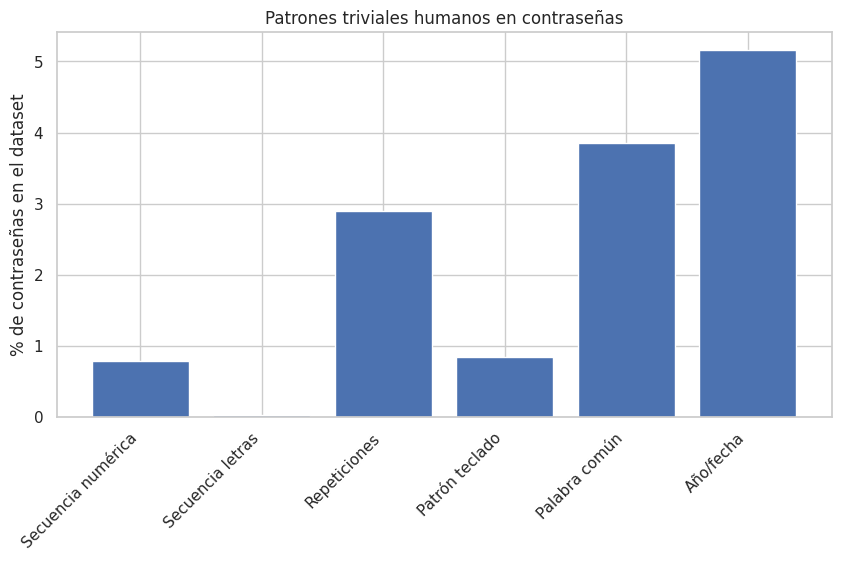

In [16]:
plt.bar(patterns.keys(), [v*100 for v in patterns.values()])
plt.ylabel("% de contraseñas en el dataset")
plt.xticks(rotation=45, ha="right")
plt.title("Patrones triviales humanos en contraseñas")
plt.show()


In [17]:

ejemplos = {
    "Secuencia numérica": df.loc[df["has_seq_num"], "password"].head(10).tolist(),
    "Secuencia letras":   df.loc[df["has_seq_alpha"], "password"].head(10).tolist(),
    "Repeticiones":       df.loc[df["has_repeat"], "password"].head(10).tolist(),
    "Patrón teclado":     df.loc[df["has_keyboard"] & ~df["has_seq_num"], "password"].head(10).tolist(),
    "Palabra común":      df.loc[df["has_common"], "password"].head(10).tolist(),
    "Año/fecha":          df.loc[df["has_year"], "password"].head(10).tolist(),
}
ejemplos


{'Secuencia numérica': ['123456',
  '12345',
  '123456789',
  '1234567',
  '12345678',
  '654321',
  '1234567890',
  '987654321',
  '987654',
  '456789'],
 'Secuencia letras': ['abcdef',
  'abcdefg',
  'abcd1234',
  'abcde',
  'abcdefgh',
  '1234abcd',
  'abcd123',
  'abcdefghij',
  'abcdefg1',
  'abcdef1'],
 'Repeticiones': ['111111',
  '000000',
  '666666',
  '555555',
  '999999',
  '11111',
  '7777777',
  '222222',
  '00000',
  '55555'],
 'Patrón teclado': ['qwerty',
  'zxcvbnm',
  'asdfgh',
  'qwertyuiop',
  'asdfghjkl',
  'qwerty1',
  'zxcvbn',
  'qwert',
  'asdfg',
  'liberty'],
 'Palabra común': ['password',
  'princess',
  'nicole',
  'daniel',
  'monkey',
  'lovely',
  'jessica',
  'michael',
  'ashley',
  'michelle'],
 'Año/fecha': ['5201314',
  '202020',
  '020202',
  '619619',
  '19871987',
  '19891989',
  '19921992',
  '19861986',
  '19931993',
  '19941994']}

### **10. Longitud vs Entropía** ###

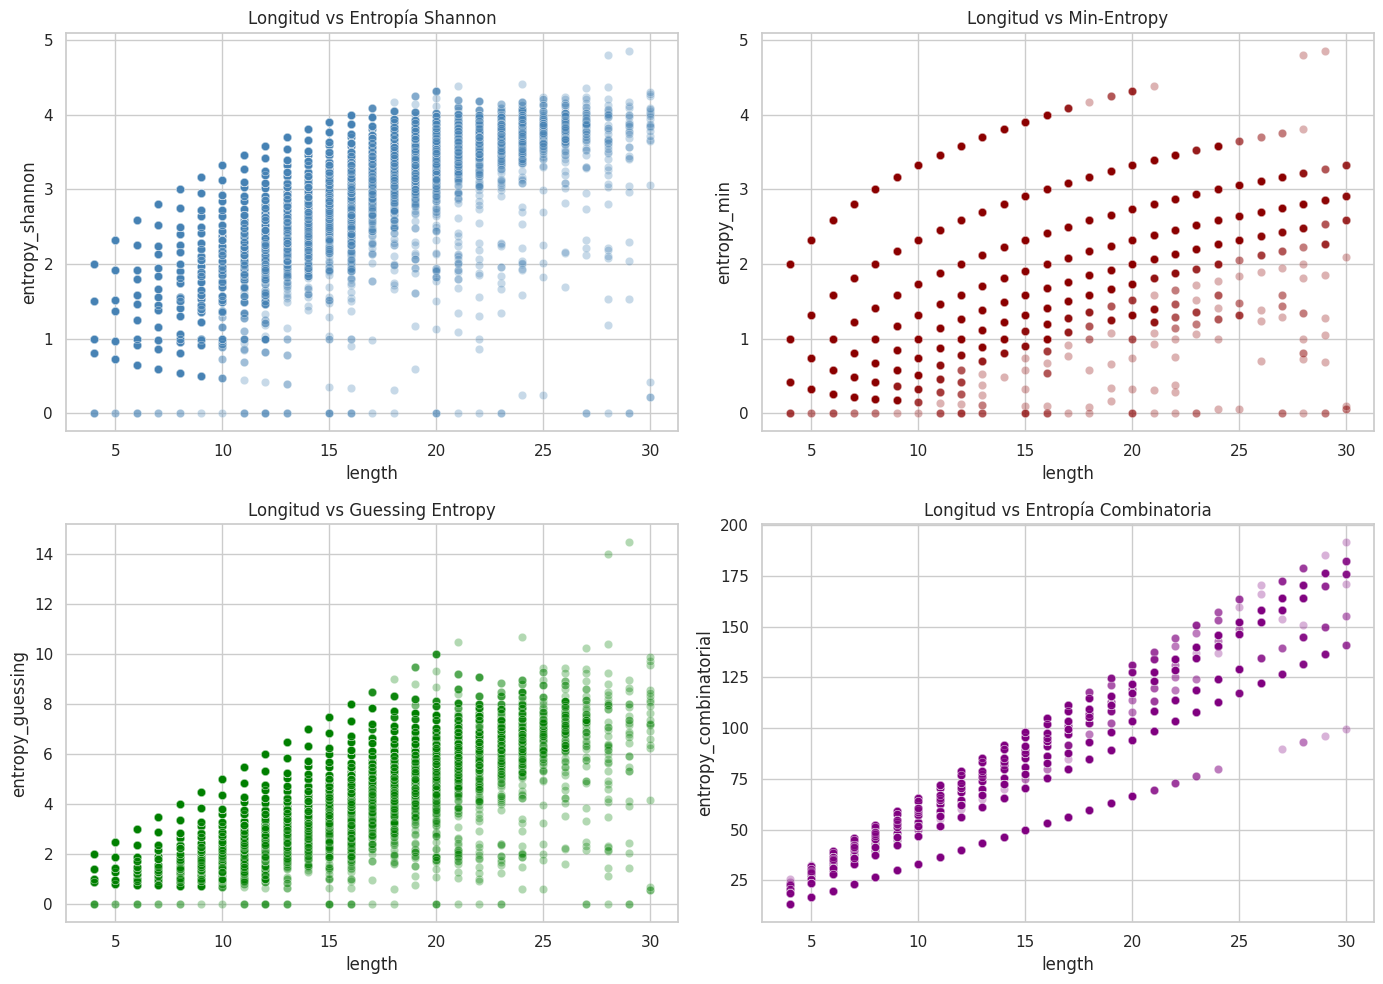

In [19]:
sample_df = df.sample(min(500000, len(df)), random_state=42)

fig, axes = plt.subplots(2, 2, figsize=(14,10))

sns.scatterplot(
    data=sample_df, x="length", y="entropy_shannon",
    alpha=0.3, ax=axes[0,0], color="steelblue"
)
axes[0,0].set_title("Longitud vs Entropía Shannon")

sns.scatterplot(
    data=sample_df, x="length", y="entropy_min",
    alpha=0.3, ax=axes[0,1], color="darkred"
)
axes[0,1].set_title("Longitud vs Min-Entropy")

sns.scatterplot(
    data=sample_df, x="length", y="entropy_guessing",
    alpha=0.3, ax=axes[1,0], color="green"
)
axes[1,0].set_title("Longitud vs Guessing Entropy")

sns.scatterplot(
    data=sample_df, x="length", y="entropy_combinatorial",
    alpha=0.3, ax=axes[1,1], color="purple"
)
axes[1,1].set_title("Longitud vs Entropía Combinatoria")

plt.tight_layout()
plt.show()


### **11.WordCloud de contraseñas comunes** ###



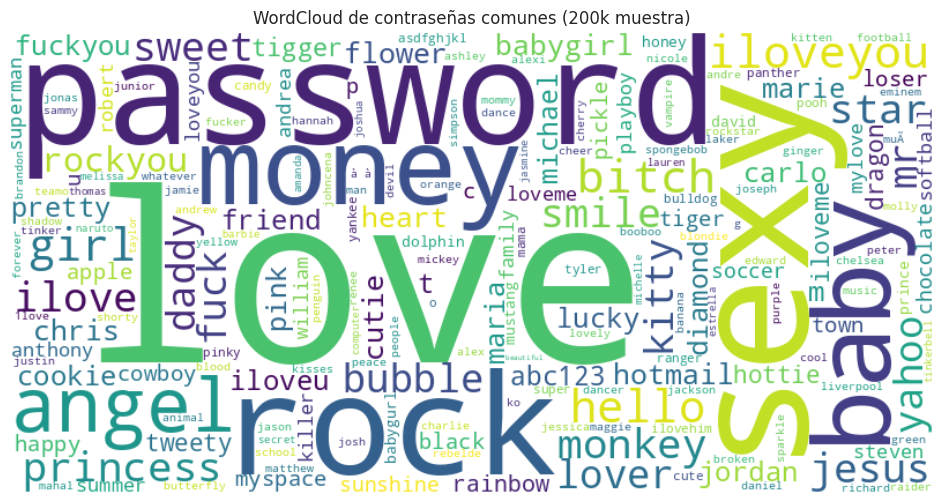

In [20]:
text = " ".join(df["password"].astype(str).values[:200000]) 
wc = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud de contraseñas comunes (200k muestra)")
plt.show()


Estimación NIST de entropía

Estadísticas de entropía NIST (bits):
count    1.433758e+07
mean     2.392598e+01
std      5.392828e+00
min      1.000000e+01
25%      2.000000e+01
50%      2.400000e+01
75%      2.700000e+01
max      6.900000e+01
Name: entropy_nist, dtype: float64


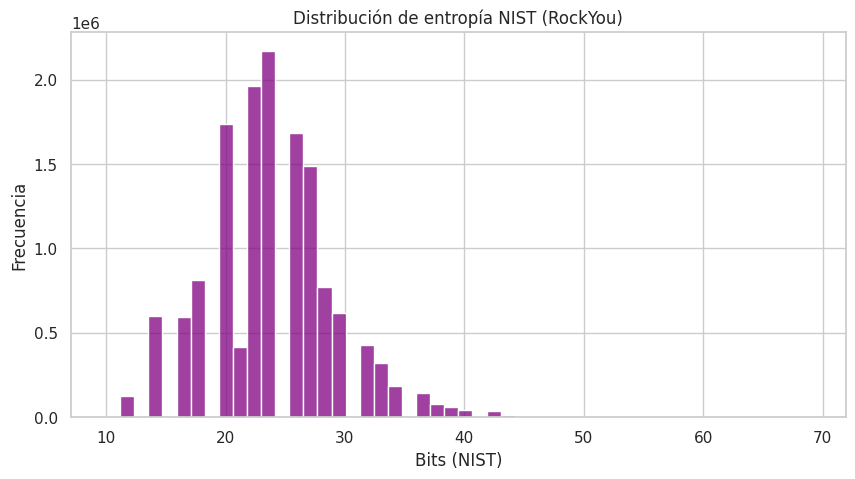

In [21]:
def nist_entropy(pwd: str) -> float:
    length = len(pwd)
    if length == 0:
        return 0
    
    entropy = 4  # primer carácter
    
    if length > 1:
        # hasta el 8
        extra = min(length-1, 7) * 2
        entropy += extra
        
    if length > 8:
        entropy += (length-8) * 1.5
    
    # Bonus por diversidad
    if any(c.isdigit() for c in pwd):
        entropy += 6
    if any(c.isupper() for c in pwd):
        entropy += 6
    if any(not c.isalnum() for c in pwd):
        entropy += 6
    
    return entropy

df["entropy_nist"] = df["password"].astype(str).apply(nist_entropy)

print("Estadísticas de entropía NIST (bits):")
print(df["entropy_nist"].describe())

sns.histplot(df["entropy_nist"], bins=50, color="purple")
plt.title("Distribución de entropía NIST (RockYou)")
plt.xlabel("Bits (NIST)")
plt.ylabel("Frecuencia")
plt.show()


KL-divergence

KL-divergence (RockYou vs Uniforme): 1.3281 bits


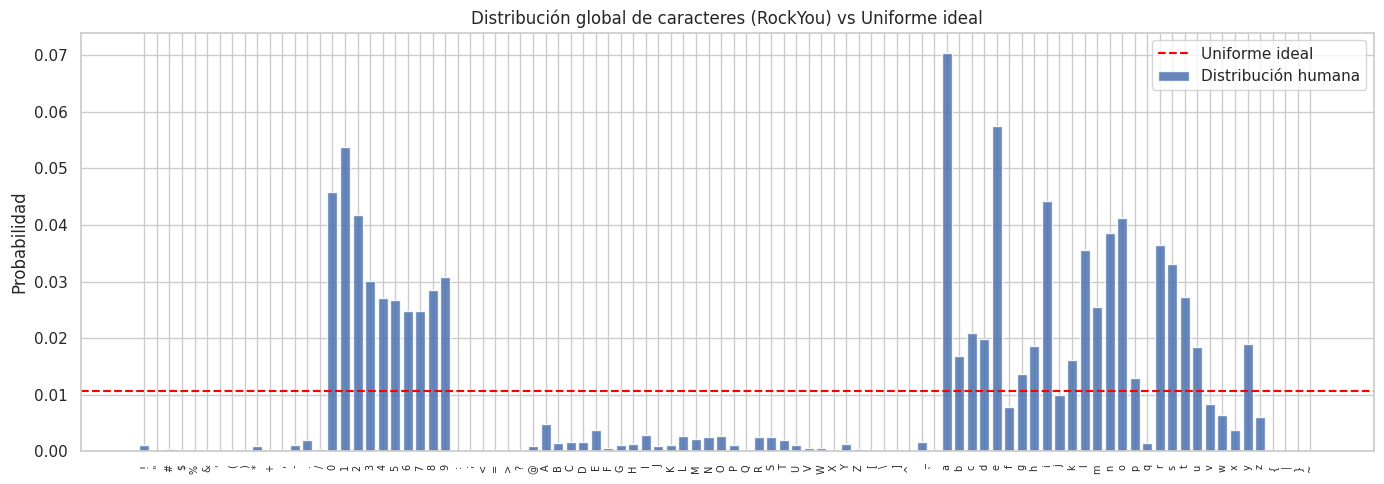

In [22]:
from collections import Counter
import math, string

alphabet = string.ascii_lowercase + string.ascii_uppercase + string.digits + string.punctuation
N = len(alphabet)

all_chars = "".join(df["password"].astype(str).values)
freqs = Counter(all_chars)
total_chars = sum(freqs.values())

p = [cnt/total_chars for cnt in freqs.values() if cnt > 0]
uniform_prob = 1 / N

KL_div_humans = sum(pi * math.log2(pi / uniform_prob) for pi in p if pi > 0)

print(f"KL-divergence (RockYou vs Uniforme): {KL_div_humans:.4f} bits")

# Visualización
obs_probs = pd.Series({c: freqs.get(c, 0)/total_chars for c in alphabet}).sort_index()

plt.figure(figsize=(14,5))
plt.bar(obs_probs.index, obs_probs.values, label="Distribución humana", alpha=0.85)
plt.axhline(uniform_prob, color="red", linestyle="dashed", label="Uniforme ideal")
plt.xticks(rotation=90, fontsize=7)
plt.ylabel("Probabilidad")
plt.title("Distribución global de caracteres (RockYou) vs Uniforme ideal")
plt.legend()
plt.tight_layout()
plt.show()
